In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Importing Dataset

In [5]:
data = pd.read_csv("D:\POLTEKSSN/TINGKAT 3/Rekayasa Sosial/Chrome-Extension-Phishing/back-end/phishing.csv")
data = data.drop(['Index'], axis=1)

In [6]:
# Preprocessing
X = data.drop(["class"], axis=1)
y = data["class"]

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Convert target to 0/1
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

In [9]:
# Model Training
models = {
    "XGBoost": XGBClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

In [11]:
# Evaluation Function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': cm,
        'y_proba': y_proba
    }

In [12]:
# Train and Evaluate All Models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    results[name] = evaluate_model(model, X_test, y_test)

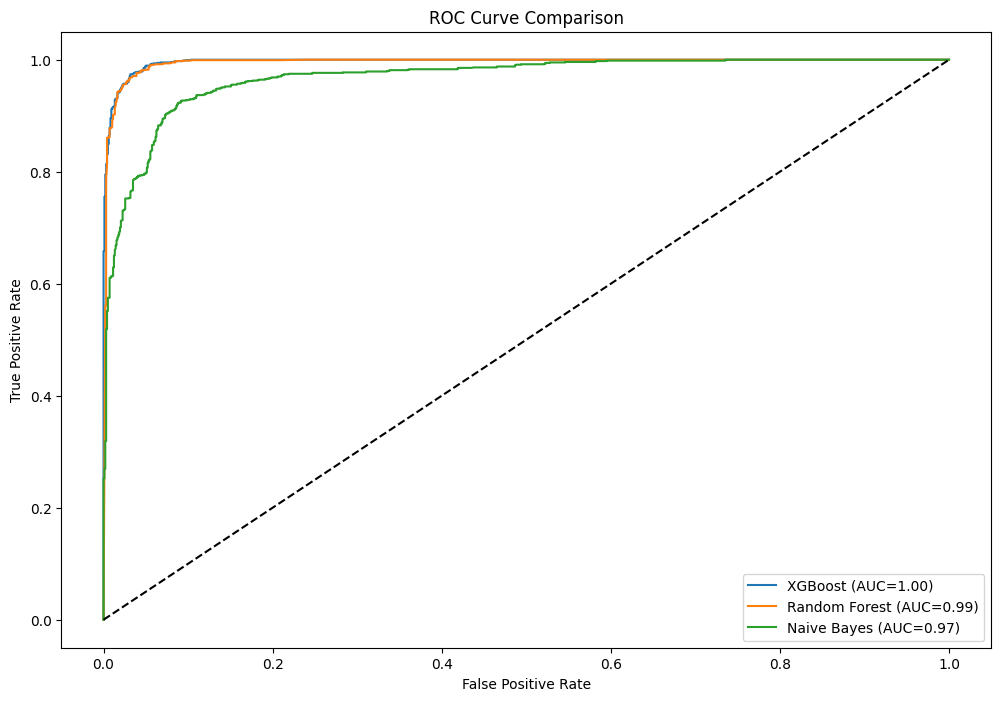

In [13]:
# Visual Comparison
## ROC Curve
plt.figure(figsize=(12, 8))
for name, res in results.items():
    if not np.isnan(res['ROC-AUC']):
        fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={res['ROC-AUC']:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

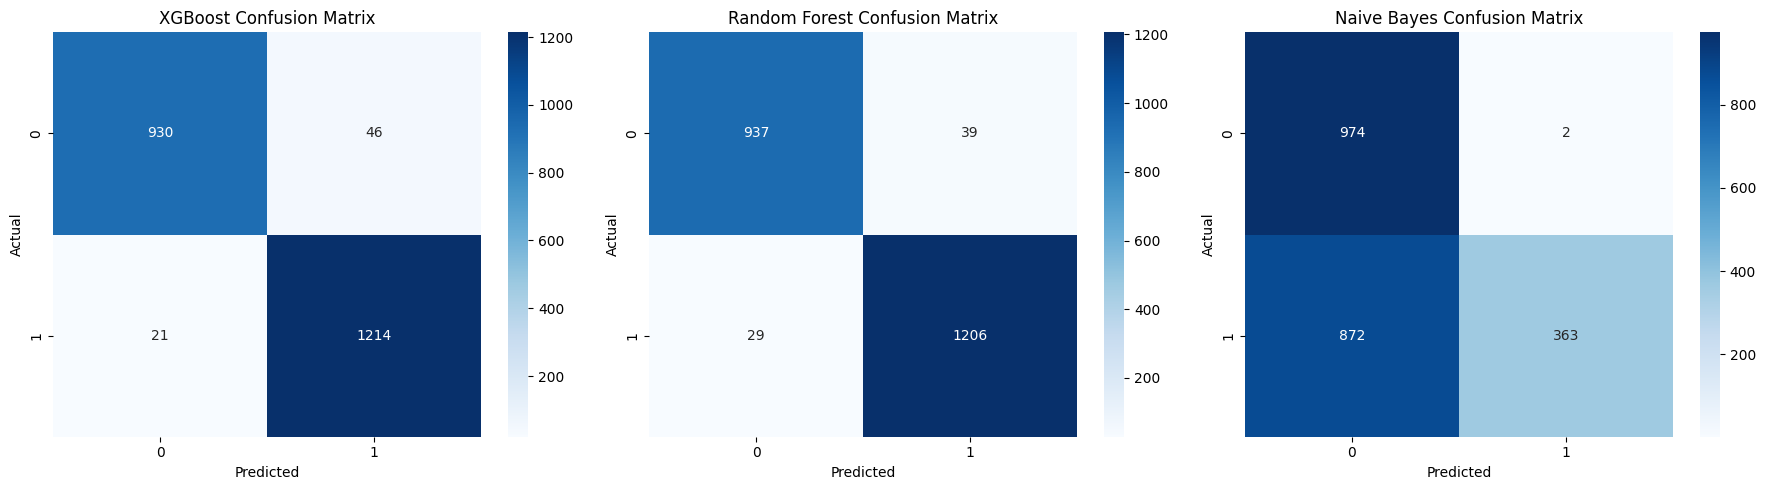

In [14]:
## Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for (name, res), ax in zip(results.items(), axes):
    sns.heatmap(res['Confusion Matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [15]:
## Performance Table
comparison_df = pd.DataFrame({
    model: {metric: score for metric, score in res.items() if metric not in ['Confusion Matrix', 'y_proba']}
    for model, res in results.items()
}).T.round(3)

print("Model Performance Comparison:")
display(comparison_df)

Model Performance Comparison:


Accuracy  Precision  Recall  F1-Score  ROC-AUC
XGBoost           0.970      0.963   0.983     0.973    0.996
Random Forest     0.969      0.969   0.977     0.973    0.995
Naive Bayes       0.605      0.995   0.294     0.454    0.968

In [16]:
# Error Analysis
def analyze_errors(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = X_test[y_pred != y_test]
    error_labels = y_test[y_pred != y_test]
    return pd.concat([errors, error_labels], axis=1)

In [17]:
# Example for XGBoost
print("XGBoost Error Analysis Sample:")
display(analyze_errors(models["XGBoost"], X_test, y_test).head())

XGBoost Error Analysis Sample:


UsingIP  LongURL  ShortURL  Symbol@  Redirecting//  PrefixSuffix-  \
9215         1       -1         1        1              1             -1   
3078         1       -1         1        1              1             -1   
8765         1       -1         1       -1              1             -1   
2167         1       -1         1        1              1             -1   
10238        1        1         1        1              1             -1   

       SubDomains  HTTPS  DomainRegLen  Favicon  ...  UsingPopupWindow  \
9215            1      1            -1        1  ...                 1   
3078            0     -1            -1        1  ...                 1   
8765            0     -1            -1        1  ...                 1   
2167           -1      1            -1        1  ...                 1   
10238           0     -1            -1        1  ...                 1   

       IframeRedirection  AgeofDomain  DNSRecording  WebsiteTraffic  PageRank  \
9215                   1            1             1              -1        -1   
3078                   1           -1             1               1        -1   
8765                   1            1             1               1        -1   
2167                   1           -1             1               0        -1   
10238                  1            1             1               1         1   

       GoogleIndex  LinksPointingToPage  StatsReport  class  
9215             1                    0            1      0  
3078             1                    0           -1      0  
8765             1                    0            1      0  
2167             1                    0            1      0  
10238            1                    0            1      0  

[5 rows x 31 columns]

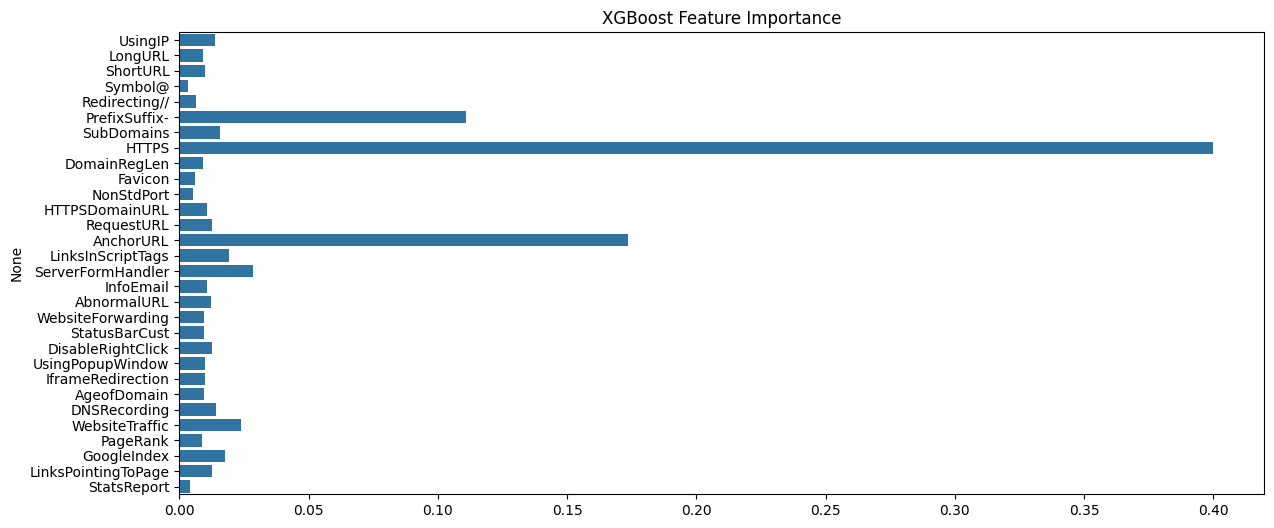

In [18]:
# Feature Importance
plt.figure(figsize=(14, 6))
sns.barplot(x=models["XGBoost"].feature_importances_, 
            y=X.columns)
plt.title('XGBoost Feature Importance')
plt.show()

In [19]:
# Save Models
import joblib
joblib.dump(models["XGBoost"], "xgboost_phishing.pkl")
joblib.dump(models["Random Forest"], "rf_phishing.pkl")
joblib.dump(models["Naive Bayes"], "nb_phishing.pkl")

['nb_phishing.pkl']